In [10]:
%pip install pygraphviz 
# neo4j langchain-experimental --q
# # install the required libaries
# ! pip install google-generativeai --quiet
# ! pip install pypdf --quiet # required for LangChain pdf reader
# #! pip install tiktoken --quiet # required for splitting document by number of tokens
# ! pip install sentence_transformers --quiet # for creating embeddings

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp310-cp310-linux_x86_64.whl size=168636 sha256=93e92ecac535d1cb8987ca62b5a5f1ad777713360ef46f81133ae7a2956f0215
  Stored in directory: /home/nikunj/.cache/pip/wheels/61/ab/cd/e24a22c32830b8b4948c8887d8714d399f0f806f206a034698
Successfully built pygraphviz
Note: you may need to restart the kernel to use updated packages.


### Loading text file (Parsed PDF into .txt file)

In [ ]:
from langchain_community.document_loaders import TextLoader

Data_Book = './sample.txt'

pdf_loader = TextLoader(file_path=Data_Book)
Data_Book = pdf_loader.load_and_split()

In [ ]:
len(Data_Book)

1

In [ ]:
Data_Book[:5]

[Document(metadata={'source': './sample.txt'}, page_content='Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\nShe was, in 1906, the first woman to become a professor at the University of Paris.')]

In [ ]:
Data_Book[0].page_content

'Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\nShe was, in 1906, the first woman to become a professor at the University of Paris.'

### LLM using Azure OpenAI

In [5]:
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
load_dotenv()

llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",  
    api_version="2024-08-01-preview", 
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

### Graph and GraphIndex Creation

In [ ]:
from langchain.indexes import GraphIndexCreator

index_creator = GraphIndexCreator(llm=llm)

graph = index_creator.from_text(Data_Book[0].page_content)

### Triples - relationship in graphs

In [7]:
graph.get_triples()

[('Marie Curie', '1867', 'born in'),
 ('Marie Curie',
  'Polish and naturalised-French physicist and chemist',
  'was a'),
 ('Marie Curie', 'pioneering research on radioactivity', 'conducted'),
 ('Marie Curie', 'a Nobel Prize', 'was the first woman to win'),
 ('Marie Curie', 'a Nobel Prize twice', 'was the first person to win'),
 ('Marie Curie',
  'a Nobel Prize in two scientific fields',
  'was the only person to win'),
 ('Pierre Curie', 'her first Nobel Prize', 'was a co-winner of')]

### Visualizing a sample graph

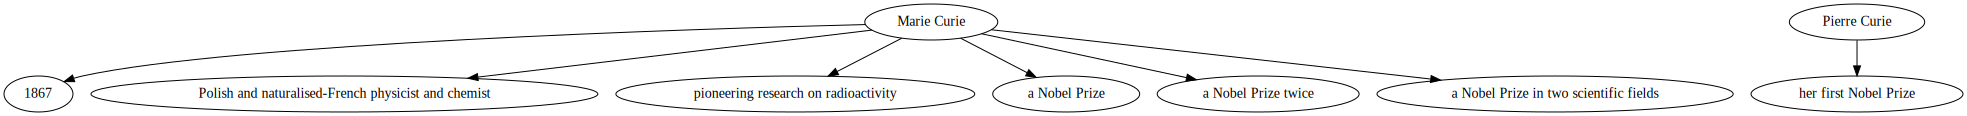

In [11]:
from IPython.display import SVG
graph.draw_graphviz(path="book.svg")
SVG('book.svg')

### Creating graph for set of Page Contents

In [ ]:
graphs = [
    index_creator.from_text(doc.page_content) 
    for doc in Data_Book
]

### compose(G, H) in networkx
Compose graph G with H by combining nodes and edges into a single graph.

Returns
A new graph with the same type as G

In [13]:
import networkx as nx

graph_nx = graphs[0]._graph
for g in graphs[1:]:
    graph_nx = nx.compose(graph_nx, g._graph)

In [14]:
from langchain.graphs.networkx_graph import NetworkxEntityGraph

graph = NetworkxEntityGraph(graph_nx)
graph

## Drawing and Saving the Graph

In [ ]:
# graph.draw_graphviz(path="Data_Book.pdf", prog='fdp')

In [ ]:
import pickle

pickle.dump(graph, open('sample.pkl', 'wb'))
# graph = pickle.load(open('sample.pkl', 'rb'))

### GraphQAChain

In [17]:
from langchain.chains import GraphQAChain


chain = GraphQAChain.from_llm(
    llm=llm, 
    graph=graph, 
    verbose=True
)

question = """
who is Marie Curie?
"""

chain.invoke(question)



> Entering new GraphQAChain chain...
Entities Extracted:
Marie Curie
Full Context:
Marie Curie was born in 1867
Marie Curie was a physicist
Marie Curie was a chemist
Marie Curie conducted pioneering research on radioactivity
Marie Curie was the first woman to win a Nobel Prize
Marie Curie won the Nobel Prize twice
Marie Curie was the only person to win a Nobel Prize in two scientific fields
Marie Curie was the first person to win a Nobel Prize twice
Marie Curie was the first woman to become a professor at the University of Paris

> Finished chain.


{'query': '\nwho is Marie Curie?\n',
 'result': 'Marie Curie was a renowned physicist and chemist who conducted pioneering research on radioactivity. She was born in 1867 and was the first woman to win a Nobel Prize. She won the Nobel Prize twice and was the only person to win a Nobel Prize in two scientific fields. Additionally, Marie Curie was the first woman to become a professor at the University of Paris.'}

In [19]:
question = """
In which 2 fields did marie curie won nobel prize?
"""

chain.invoke(question)



> Entering new GraphQAChain chain...
Entities Extracted:
marie curie, nobel prize
Full Context:


> Finished chain.


{'query': '\nIn which 2 fields did marie curie won nobel prize?\n',
 'result': 'Marie Curie won Nobel Prizes in the fields of Physics and Chemistry.'}

In [21]:
question = """
who is husband of first woman to win a nobel prize?
"""

chain.invoke(question)



> Entering new GraphQAChain chain...
Entities Extracted:
NONE
Full Context:


> Finished chain.


{'query': '\nwho is husband of first woman to win a nobel prize?\n',
 'result': 'Marie Curie was the first woman to win a Nobel Prize. Her husband was Pierre Curie.'}